In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# 1 Least squares and linear basis functions models
## 1.1 Least squares

In [140]:
def least_squares(y, tx):
    """calculate the least squares solution."""
    #a = tx.T.dot(tx)
    #b = tx.T.dot(y)
    #return np.linalg.solve(a, b)
    w = np.linalg.inv(tx.T @ tx) @ tx.T @ y
    return 1 / 2 * np.mean((y - tx.dot(w)) ** 2), w

### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [141]:
from helpers import *
def test_your_least_squares():
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)
    w, err = least_squares(y, tx)
    print(w)
    print(err)

Test it here

In [142]:
test_your_least_squares()

15.3858878688294
[73.293922   13.47971243]


## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [143]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [144]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    return (x.reshape(x.shape[0], 1) ** np.arange(degree + 1))

Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

In [175]:
from plots import *

def calculate_mse(e):
    """Calculate the mse for vector e."""
    return 1/2*np.mean(e**2)

def polynomial_regression():
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]
    
    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):
        tx = build_poly(x, degree)
        err, weights = least_squares(y, tx)
        rmse = np.sqrt(2 * err)
        print("Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse))
        # plot fit
        plot_fitted_curve(
            y, x, weights, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()
    plt.savefig("visualize_polynomial_regression")
    plt.show()

Run polynomial regression

Processing 1th experiment, degree=1, rmse=0.47187607963421874
Processing 2th experiment, degree=3, rmse=0.258582776677375
Processing 3th experiment, degree=7, rmse=0.2496587036090753
Processing 4th experiment, degree=12, rmse=0.9268294530625559


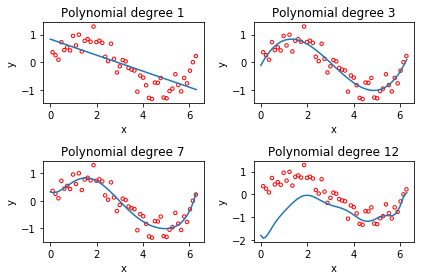

In [176]:
polynomial_regression()

# 2 Evaluating model predication performance


Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [173]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    # set seed
    np.random.seed(seed)
    train_size = int(ratio * len(x))
    train_indices = np.random.permutation(len(x))[:train_size]
    test_indices = np.random.permutation(len(x))[train_size:]
    x_train = x[train_indices]
    y_train = y[train_indices]
    x_test = x[test_indices]
    y_test = y[test_indices]
    assert(x_train.shape[0] + x_test.shape[0] == x.shape[0])
    assert(y_train.shape[0] + y_test.shape[0] == y.shape[0])
    return x_train, y_train, x_test, y_test

Then, test your `split_data` function below.

In [181]:
def compute_rmse(y, tx, w):
    e = y - tx @ w
    return np.sqrt(2 * calculate_mse(e))

def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees."""
    x_train, y_train, x_test, y_test = split_data(x, y, ratio, seed)
    x_train = build_poly(x_train, degree)
    x_test = build_poly(x_test, degree)
    err, weight = least_squares(y_train, x_train)
    rmse_tr = compute_rmse(y_train, x_train, weight)
    rmse_te = compute_rmse(y_test, x_test, weight)
    print("proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
          p=ratio, d=degree, tr=rmse_tr, te=rmse_te))


In [182]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.5, 0.1]

for split_ratio in split_ratios:
    for degree in degrees:
        train_test_split_demo(x, y, degree, split_ratio, seed)

proportion=0.9, degree=1, Training RMSE=0.494, Testing RMSE=0.366
proportion=0.9, degree=3, Training RMSE=0.264, Testing RMSE=0.196
proportion=0.9, degree=7, Training RMSE=0.254, Testing RMSE=0.254
proportion=0.9, degree=12, Training RMSE=2.159, Testing RMSE=2.431
proportion=0.5, degree=1, Training RMSE=0.455, Testing RMSE=0.324
proportion=0.5, degree=3, Training RMSE=0.239, Testing RMSE=0.237
proportion=0.5, degree=7, Training RMSE=0.232, Testing RMSE=0.235
proportion=0.5, degree=12, Training RMSE=0.423, Testing RMSE=0.444
proportion=0.1, degree=1, Training RMSE=0.428, Testing RMSE=0.526
proportion=0.1, degree=3, Training RMSE=0.085, Testing RMSE=0.441
proportion=0.1, degree=7, Training RMSE=4.466, Testing RMSE=3.807
proportion=0.1, degree=12, Training RMSE=101.561, Testing RMSE=73.500


# 3 Ridge Regression
Please fill in the function below.

In [183]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression."""
    aI = 2 * tx.shape[0] * lambda_ * np.identity(tx.shape[1])
    a = tx.T.dot(tx) + aI
    b = tx.T.dot(y)
    return np.linalg.solve(a, b)

In [202]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)
    x_train, y_train, x_test, y_test = split_data(x, y, ratio, seed)
    x_train = build_poly(x_train, degree)
    x_test = build_poly(x_test, degree)
    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        weights = ridge_regression(y_train, x_train, lambda_)
        rmse_tr.append(compute_rmse(y_train, x_train, weights))
        rmse_te.append(compute_rmse(y_test, x_test, weights))
        print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
        
    # Plot the obtained results
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)


proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.298
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.297
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.297
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.297
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.228, Testing RMSE=0.296
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.228, Testing RMSE=0.296
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.229, Testing RMSE=0.293
proportion=0.5, degree=7, lambda=0.003, Training RMSE=0.230, Testing RMSE=0.285
proportion=0.5, degree=7, lambda=0.007, Training RMSE=0.232, Testing RMSE=0.273
proportion=0.5, degree=7, lambda=0.016, Training RMSE=0.237, Testing RMSE=0.260
proportion=0.5, degree=7, lambda=0.037, Training RMSE=0.246, Testing RMSE=0.260
proportion=0.5, degree=7, lambda=0.085, Training RMSE=0.264, Testing RMSE=0.285
proportion=0.5, degree=7, lambda=0.193, 

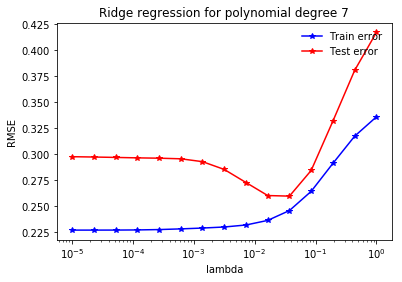

In [203]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)